# Feature Engineering

https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12586969.1002.9.3b30b135yt4vF1&postId=129321

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

In [2]:
data_train = pd.read_csv('originalDataset/train.csv')
data_test_a = pd.read_csv('originalDataset/testA.csv')

In [14]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

see null values: 

In [4]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

Fill the null. Some other schemes can be used. 

In [5]:
#按照平均数填充数值型特征
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median())
#按照众数填充类别型特征
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())

process the dates: 

In [6]:
#转化成时间格式
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

change the `object` type into a numerical type: 

In [7]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

In [8]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0]) ## mind this. use the int type in np, not general python int. 
    
for data in [data_train, data_test_a]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [9]:
for data in [data_train, data_test_a]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda x: int(x[-4:]))

**Mind this**: the `earliesCreditLine` was MMM-YYYY, but after the following preprocess, this column only has YYYY. 

So in the future, we may find other ways to preprocess this column. 

In [10]:
data_train['earliesCreditLine'].sample(5)

71528     1993
154212    1985
324650    1977
413573    1977
646404    2009
Name: earliesCreditLine, dtype: int64

Use label encoding to change other object type columns. 

In [11]:
for data in [data_train, data_test_a]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [12]:
# 类型数在2之上，又不是高维稀疏的,且纯分类特征
for data in [data_train, data_test_a]:
    data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

Find outlier, especially for numerical data that are outside of the range (3 * standard error). 

In [13]:
def find_outliers_by_3segama(data,fea):
    stdError = np.std(data[fea])
    meanVal = np.mean(data[fea])
    lowerBound = meanVal - 3*stdError
    higherBound = meanVal + 3*stdError
    data[fea+'_outliers'] = data[fea].apply(lambda x: str('异常值') if x < lowerBound or x > higherBound else str('正常值'))
    return data

`isDefault` is the label column. 

The meaning of the outputs of the following cell is that: _in each column, rows are grouped by `正常值` or `异常值`, and the `sum()` will be the sum of multiple '1's and '0's. E.g., in column `interestRate_outliers`, there are 150000+ 正常值 rows that are positive labeled, and there are 2916 异常值 rows that are positive labeled._

In [14]:
data_train = data_train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print("-"*10)
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)
    print()

正常值    800000
Name: id_outliers, dtype: int64
----------
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********

正常值    800000
Name: loanAmnt_outliers, dtype: int64
----------
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********

正常值    800000
Name: term_outliers, dtype: int64
----------
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********

正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
----------
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********

正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
----------
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********

正常值    800000
Name: employmentTitle_outliers, dtype: int64
----------
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********

正常值    799701
异常值       299
Name: homeOwnership_outliers, dtype: int64
----------
homeOwnership_outliers
异常值      

In [15]:
data_train.head(3).append(data_train.tail(3))

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5_outliers,n6_outliers,n7_outliers,n8_outliers,n9_outliers,n10_outliers,n11_outliers,n12_outliers,n13_outliers,n14_outliers
0,0,35000.0,5,19.52,917.97,5,E2,320.0,2.0,2,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值
1,1,18000.0,5,18.49,461.90,4,D2,219843.0,5.0,0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值
2,2,12000.0,5,16.99,298.17,4,D3,31698.0,8.0,0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值
799997,799997,6000.0,3,13.33,203.12,3,C3,2582.0,10.0,1,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值
799998,799998,19200.0,3,6.92,592.14,1,A4,151.0,10.0,0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值
799999,799999,9000.0,3,11.06,294.91,2,B3,13.0,5.0,0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值


Delete 异常值, which is abnormal values. 

Only the rows that all numerical columns are normal values will be kept. Other rows will be given up. 

**Mind this**: sometimes abnormal values cannot be removed. They should also be kept, because sometimes the abnormal values can lead to discoveries. 

In [16]:
#删除异常值
for fea in numerical_fea:
    data_train = data_train[data_train[fea+'_outliers']=='正常值']
    data_train = data_train.reset_index(drop=True) 

Distribute the data into bins: 

In [17]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)

In [18]:
## 通过对数函数映射到指数宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))

In [19]:
data['loanAmnt_bin3'] = pd.qcut(data['loanAmnt'], 10, labels=False)

Combinatorial features（交互特征）is the combination of original features. https://www.msra.cn/zh-cn/news/features/kdd-2018-xdeepfm#:~:text=%E7%89%B9%E5%BE%81%E4%BA%A4%E4%BA%92%E6%8C%87%E7%9A%84%E6%98%AF,user_id%2C%20item_id%5D%E7%9A%84%E8%81%94%E7%B3%BB%E3%80%82

**Mind this**: there may be multiple ways of combining features. Try more methods. 

In [46]:
## 这里的target mean, 就跟我之前那个kaggle项目用的target encoding在思路上有一定的类似之处.
## 但是这里的具体算法又不太一样. 
## 这里的算法是: 
### 将col进行分组, 求每一个分组里面的label的总和的平均值是多少
## 然后再映射一下, 构建新的列. 
## 这里就是一种combination的方法了, 可以学习一下. 
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    print(temp_dict.head())
    temp_dict = temp_dict[col + '_target_mean'].to_dict()
    print(col, " ", temp_dict, sum(temp_dict.values()), "\n")

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)


   grade  grade_target_mean
1      1           0.059838
2      2           0.131210
3      3           0.224522
4      4           0.304227
5      5           0.386234
grade   {1: 0.05983754010496838, 2: 0.1312100457861034, 3: 0.22452249131030422, 4: 0.30422665003427624, 5: 0.3862340548898338, 6: 0.4509921313718782, 7: 0.45314009661835747} 2.010163010115722 

   subGrade  subGrade_target_mean
A1       A1              0.032617
A2       A2              0.044493
A3       A3              0.053966
A4       A4              0.065532
A5       A5              0.083522
subGrade   {'A1': 0.03261699574560925, 'A2': 0.04449302765303711, 'A3': 0.05396644867785044, 'A4': 0.06553160215580597, 'A5': 0.08352181466548661, 'B1': 0.10053276344700961, 'B2': 0.1094614852398524, 'B3': 0.12811052672894263, 'B4': 0.14836514352965255, 'B5': 0.16260956738554866, 'C1': 0.1912715651761416, 'C2': 0.2040048707887972, 'C3': 0.22468573405604889, 'C4': 0.2515842653973075, 'C5': 0.2622187489824493, 'D1': 0.27944432385500

In [21]:
# 其他衍生变量 mean 和 std
## 我认为, 这一部的操作增加的是什么呢? 
## 除号右边那个部分得到的是: 按照nx分组, 每一组求一个平均数, 然后把这个平均数赋给每一行数据, 让每一行数据自己认领一个属于自己的平均数值. 
## 结合上除号, 就得到的是: 每一行数据的等级分除以每一行数据对应的平均分, 得到的商. 
## 学习一下, 如果要进行特征组合, 多采用这里面用到的方法, 诸如groupby, transform之类. 
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [26]:
data_train[['grade', 'subGrade', 'grade_target_mean', "subGrade_target_mean"]].head()

,grade,subGrade,grade_target_mean,subGrade_target_mean
0,5,E2,0.386234,0.380444
1,4,D2,0.304227,0.298190
2,4,D3,0.304227,0.302541
3,1,A4,0.059838,0.065532
4,3,C3,0.224522,0.224686


In [42]:
df.groupby(["n0"])['grade'].transform('mean')

0         2.901111
1         2.905480
2         2.701633
3         2.701633
4         2.701633
            ...   
199995    2.701633
199996    2.701633
199997    2.701633
199998    2.701633
199999    2.701633
Name: grade, Length: 200000, dtype: float64

In [43]:
df.groupby(["n0"])['grade'].mean()

n0
0.0     2.701633
1.0     2.901111
2.0     2.905480
3.0     2.904849
4.0     2.909639
5.0     2.891909
6.0     2.894180
7.0     2.846405
8.0     2.901449
9.0     2.903614
10.0    2.916201
11.0    2.942529
12.0    2.794872
13.0    3.117647
14.0    2.886364
15.0    2.647059
16.0    3.272727
17.0    2.812500
18.0    2.615385
19.0    4.333333
21.0    2.600000
22.0    3.000000
23.0    3.200000
24.0    1.500000
25.0    3.500000
27.0    3.500000
29.0    4.000000
30.0    4.000000
31.0    2.000000
32.0    2.000000
Name: grade, dtype: float64

Change the strings into numbers. http://sofasofa.io/forum_main_post.php?postid=1001659

In [47]:
#label-encode:subGrade,postCode,title
# 高维类别特征需要进行转换
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))
print('Label Encoding 完成')

100%|██████████| 4/4 [00:10<00:00,  2.68s/it]

Label Encoding 完成


Some examples of feature selection methods. 

**Mind that**: other methods can be chosen. 

In [51]:
from sklearn.feature_selection import VarianceThreshold
#其中参数threshold为方差的阈值
VarianceThreshold(threshold=3).fit_transform(
    data_train[['grade', 'subGrade', 'grade_target_mean', "subGrade_target_mean"]],
    data_train["isDefault"]
)

array([[21.],
       [16.],
       [17.],
       ...,
       [12.],
       [ 3.],
       [ 7.]])

In [56]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数

SelectKBest(k=3).fit_transform(
    data_train[['grade', 'subGrade', 'grade_target_mean', "subGrade_target_mean"]],
    data_train["isDefault"]
)

array([[21.        ,  0.38623405,  0.38044389],
       [16.        ,  0.30422665,  0.29818972],
       [17.        ,  0.30422665,  0.30254055],
       ...,
       [12.        ,  0.22452249,  0.22468573],
       [ 3.        ,  0.05983754,  0.0655316 ],
       [ 7.        ,  0.13121005,  0.12811053]])

In [57]:
data_train.to_csv("data_train.csv", index=False)

In [58]:
data_test_a.to_csv("data_test_a.csv", index=False)

(Directly load the csv files, don't run the notebook again)

In [2]:
data_train = pd.read_csv("data_train.csv")
data_test_a = pd.read_csv("data_test_a.csv")

In [3]:
data_train.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,0,35000.0,5,19.52,917.97,5,21,161280,2.0,2,...,1.842210,4.108917,1.852810,4.009823,1.852810,4.009823,1.857394,4.005352,1.856379,3.991791
1,1,18000.0,5,18.49,461.90,4,16,89538,5.0,0,...,1.484104,3.173687,1.482248,3.207858,1.482248,3.207858,1.485915,3.204282,1.485103,3.193433
2,2,12000.0,5,16.99,298.17,4,17,159367,8.0,0,...,1.504230,3.089208,1.482248,3.207858,1.482248,3.207858,1.485915,3.204282,1.315111,3.146801
3,6,2050.0,3,7.69,63.95,1,3,59830,9.0,0,...,0.370128,0.799459,0.370562,0.801965,0.370562,0.801965,0.371479,0.801070,0.344287,0.793451
4,7,11500.0,3,14.98,398.54,3,12,85242,1.0,1,...,1.104961,2.446307,1.111686,2.405894,1.111686,2.405894,1.114436,2.403211,1.113827,2.395075


In [4]:
data_test_a.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,800000,14000.0,3,10.99,458.28,2,7,226216,10.0,0,...,0.739364,1.546269,0.728272,1.544297,0.728493,1.544314,0.676117,1.613241,0.682304,1.531164
1,800001,20000.0,5,14.65,472.14,3,14,218168,10.0,0,...,1.074717,2.419804,1.092408,2.316446,1.092740,2.316471,1.009677,2.472946,1.104785,2.336065
2,800002,12000.0,3,19.99,445.91,4,18,102813,2.0,1,...,1.452872,3.071997,1.456544,3.088594,1.456986,3.088628,1.462954,3.082872,1.176775,2.884269
3,800003,17500.0,5,14.31,410.02,3,13,220769,4.0,0,...,1.089865,2.331753,1.092408,2.316446,1.092740,2.316471,1.097216,2.312154,1.023456,2.296746
4,800004,35000.0,3,17.09,1249.42,4,15,192707,0.0,1,...,1.468331,2.987120,1.456544,3.088594,1.456986,3.088628,1.462954,3.082872,1.562159,3.262761


Delete some useless columns

In [6]:
for data in [data_train, data_test_a]:
    data.drop(["issueDate", "id"], axis = 1, inplace = True)

Use the row above the n/a row to fill the n/a cells. In another word, fill the n/a with previous value.  

In [7]:
data_train = data_train.fillna(axis = 0, method = "ffill")

Calculate covariance: 

In [11]:
x_train = data_train.drop(['isDefault'], axis=1)
#计算协方差
data_corr = x_train.corrwith(data_train["isDefault"]) #计算相关性
data_corr

loanAmnt             0.061056
term                 0.174659
interestRate         0.254421
installment          0.043117
grade                0.256237
                       ...   
grade_to_std_n12     0.256237
grade_to_mean_n13    0.256010
grade_to_std_n13     0.256257
grade_to_mean_n14    0.243995
grade_to_std_n14     0.252988
Length: 77, dtype: float64

In [12]:
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values
result

,features,corr
0,loanAmnt,0.061056
1,term,0.174659
2,interestRate,0.254421
3,installment,0.043117
4,grade,0.256237
...,...,...
72,grade_to_std_n12,0.256237
73,grade_to_mean_n13,0.256010
74,grade_to_std_n13,0.256257
75,grade_to_mean_n14,0.243995


Visualize the correlation: 

<AxesSubplot:title={'center':'Correlation of Numeric Features with Price'}>

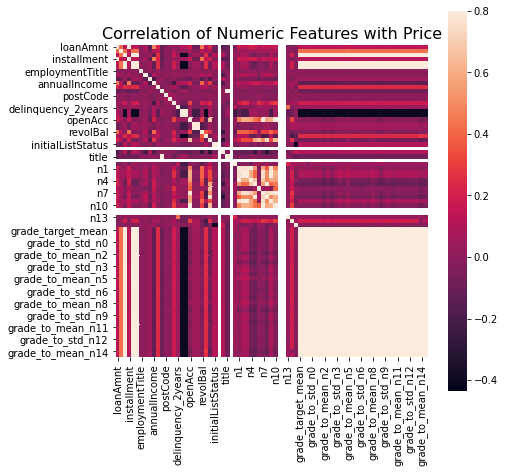

In [15]:
# 当然也可以直接看图
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()

f, ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [17]:
list(data_train.columns)

['loanAmnt',
 'term',
 'interestRate',
 'installment',
 'grade',
 'subGrade',
 'employmentTitle',
 'employmentLength',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'isDefault',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'earliesCreditLine',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14',
 'issueDateDT',
 'id_outliers',
 'loanAmnt_outliers',
 'term_outliers',
 'interestRate_outliers',
 'installment_outliers',
 'employmentTitle_outliers',
 'homeOwnership_outliers',
 'annualIncome_outliers',
 'verificationStatus_outliers',
 'purpose_outliers',
 'postCode_outliers',
 'regionCode_outliers',
 'dti_outliers',
 'delinquency_2years_outliers',
 'ficoRangeLow_outliers',
 'ficoRangeHigh_outliers',
 'openAcc_ou

Select the features that will be later used to fit the model: No `xx_outliers` features, no labels. 

In [18]:
features = [f for f in data_train.columns if f not in ['id','issueDate','isDefault'] and '_outliers' not in f]
x_train = data_train[features]
x_test = data_test_a[features]
y_train = data_train['isDefault']

### Build the classifier: 

The `clf` is the classifier. You can freely name it. 

I guess the `cv` means _cross validation_. 

KFold: https://zhuanlan.zhihu.com/p/81673486



In [20]:
np.zeros(x_train.shape[0])

array([0., 0., 0., ..., 0., 0., 0.])

API of XGBoost: https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training

Some other examples of XGB usage: https://zhuanlan.zhihu.com/p/52560971

Some explanation of the parameters and return types of the XGB: https://blog.csdn.net/weixin_42320576/article/details/88414238

**Mind this**: we can use many other classifiers. Just as shown in the following cell. 

In [21]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

At least for XGBoost, the `test_pred` will be probabilities, not the classification results. See https://blog.csdn.net/weixin_42320576/article/details/88414238 

In [22]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")

In [23]:
## Don't do this on my laptop. 
# lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

Finally, get AUC: 

Don't actually run it. I don't think we got the test result data for the final evaluation. 

In [ ]:
testA_result = pd.read_csv('../testA_result.csv')

In [ ]:
roc_auc_score(testA_result['isDefault'].values, lgb_test)